In [1]:
## Goals
# Computer experiments:
# Rate and state friction with two state-variables.
# Deterministic chaos.
# Becker (2000), Deterministic Chaos in two State-variable Friction Sliders and the Effect of Elastic Interactions.

In [2]:
%pip install -q ipywidgets matplotlib numpy scipy pandas
import numpy    as     np
import ode      as odeLib        # our ODE routines
import matplotlib.pyplot as plt
from   scipy                import integrate
from   scipy                import integrate
from   ipywidgets           import *
from   IPython.display      import display

Note: you may need to restart the kernel to use updated packages.


The governing equations of a spring-slider system goverend by the rate- and state- friction with two state variables are described in Becker (2000) equations 1-3. 

Here we adopt the non-dimensionalized equations 4-6. 

\begin{align}
\dot x = e^x ((\beta_1 - 1) x + y -z) + \dot y - \dot z \\
\dot y = (1 - e^x) \kappa \\
\dot z = -e^x \rho (\beta_2 x + z)
\end{align}

where 
\begin{align}
x=ln(V/V_*) \\
y=(\tau - \tau_*)/A \\
\beta_i = B_i/A \\
\kappa = KL_1/A \\
z = \beta_2 ln(V_* \theta_2 / L_2) \\
\rho = L_1 / L_2 \\
T = V_* t / L_1 
\end{align}

In [3]:
# Solve the elastic one degree spring-slider system goverend by the rate and state friction.
# A two state variable law with Ruina ("slip") version is adopted.
# 
# define parameters for the rate- and state -friction system.
class parameters:
    beta1     = 1.
    beta2     = 0.84
    rho       = 0.048
    kappa     = None

def calcKappa(kappaPrime, par):
    beta1    = par.beta1
    beta2    = par.beta2
    rho      = par.rho
    kappaCr1 = beta1 - 1.
    kappaCr2 = (kappaCr1 + rho*(2*beta1 + (beta2 - 1.)*(2.+rho)) + \
                (4*rho**2*(kappaCr1 + beta2) + (kappaCr1 + rho**2*(beta2 - 1.)**2))**0.5) 
    kappaCr2 = kappaCr2/(2. + 2.*rho) # eq 10 in Becker (2000).
    kappa    = kappaCr2 * kappaPrime
    return kappa

# define the ODEs for the system.

# x = [x,y,z]
def fy(t,x,par):
    kappa  = par.kappa
    return (1. - np.exp(x[0])) * kappa

def fz(t,x,par):
    rho    = par.rho
    beta2  = par.beta2
    return -np.exp(x[0])*rho*(beta2*x[0] + x[2])

def fx(t,x,par):
    beta1  = par.beta1
    fytmp  = fy(t,x,par)
    fztmp  = fz(t,x,par)
    return np.exp(x[0])*((beta1 - 1.)*x[0] + x[1] - x[2]) + fytmp - fztmp 

def rsfOdeSolverTwoStateVar(time, xInit, method, ndim, par):
    # following the equations 4-6 in Becker (2000).
    # dimensionless variables x, y, z
    nstep = len(time)
    xout  = np.empty((nstep,ndim))
    
    hs    = time[1] - time[0]
    xtmp  = xInit
    func  = [fx, fy, fz]
    
    for i, t in enumerate(time):
        xout[i][:] = xtmp
        if method  == 'euler':
            xtmp   = odeLib.euler(t,xtmp,func,ndim,hs,par)
        elif method == 'midpoint':
            xtmp   = odeLib.midpoint(t,xtmp,func,ndim,hs,par)
        elif method == 'runge_kutta':
            xtmp   = odeLib.runge_kutta(t,xtmp,func,ndim,hs,par)
    resx     = xout[:,0]
    resy     = xout[:,1]
    resz     = xout[:,2]
    
    return resx, resy, resz

In [4]:
def odeF(x, t, beta1, beta2, rho, kappa):
    dotfy  = (1. - np.exp(x[0])) * kappa
    dotfz  = -np.exp(x[0])*rho*(beta2*x[0] + x[2])
    dotfx  = np.exp(x[0])*((beta1 - 1.)*x[0] + x[1] - x[2]) + dotfy - dotfz
    return [dotfx, dotfy, dotfz]

def odeSolverScipy(t, xInit, beta1, beta2, rho, kappa):
    sol  = integrate.odeint(odeF, xInit, t, args=(beta1, beta2, rho, kappa))
    resx = sol[:,0]
    resy = sol[:,1]
    resz = sol[:,2]
    return resx, resy, resz

In [5]:
def main(kappaPrime, T1, Tshow, dt, plot = True):
    par      = parameters()
    t        = np.linspace(0, T, Nt)
    ndim     = 3

    sol      = np.zeros((3,Nt))
    
    par.kappa= calcKappa(kappaPrime, par)
    xInit    = [0.05, 0., 0.] # Figure 2 in Becker (2000).
    sol      = rsfOdeSolverTwoStateVar(t, xInit, 'runge_kutta', ndim, par)
    
    if plot == True:
        fig  = plt.figure(figsize=(12,12), dpi= 100, facecolor='w', edgecolor='k')
        plt.plot(t, sol[:][1], 'k',    label='runge_kutta',       linewidth=3)
        plt.grid()
        plt.xlabel("Time, $t$")
        plt.ylabel("y")
        plt.xlim(left = T1, right = T)

    return sol

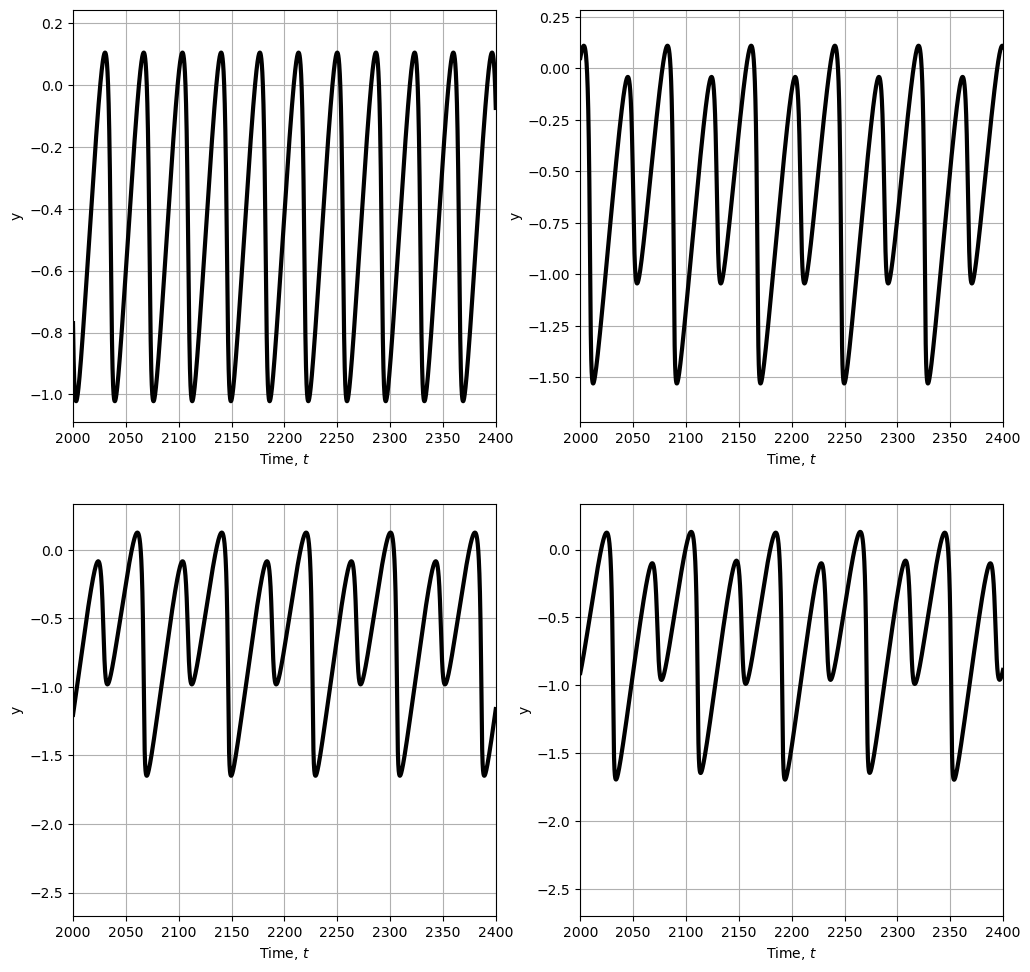

In [6]:
# plot 4 kappaPrime cases.
T1        = 2000
Tshow     = 400
T         = T1 + Tshow
dt        = 0.04
Nt        = int(T/dt)
t         = np.linspace(0, T, Nt)
res       = np.zeros((3,4,Nt))

fig       = plt.figure(figsize=(12,12), dpi= 100, facecolor='w', edgecolor='k')

kappaPrime= 0.90
res[:,0,:]  = main(kappaPrime, T1, Tshow, dt, plot=False)

kappaPrime= 0.86
res[:,1,:]  = main(kappaPrime, T1, Tshow, dt, plot=False)

kappaPrime= 0.856
res[:,2,:]  = main(kappaPrime, T1, Tshow, dt, plot=False)

kappaPrime= 0.8552
res[:,3,:]  = main(kappaPrime, T1, Tshow, dt, plot=False)

#x, y, z  = odeSolverScipy(t, xInit, par.beta1, par.beta2, par.rho, par.kappa_prime)

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(t, res[1,i,:], 'k',    label='runge_kutta',       linewidth=3)
    plt.grid()
    plt.xlabel("Time, $t$")
    plt.ylabel("y")
    plt.xlim(left = T1, right = T)

In [7]:
w = interactive(main, kappaPrime   = (0.8, 1., 0.01), 
               T1=T1, Tshow=Tshow, dt=dt, plot=True)
display(w)

interactive(children=(FloatSlider(value=0.89, description='kappaPrime', max=1.0, min=0.8, step=0.01), IntSlide…